# Identified protein of interest:
HSPA5 – heat shock protein family A (Hsp70) member 5
* https://www.ncbi.nlm.nih.gov/datasets/gene/3309/#transcripts-and-proteins

The UNIPROT ID of which is:
* NP_005338.1

In [1]:
from Bio import Entrez, SeqIO
from io import StringIO
import pandas as pd
import re
from copy import copy
from Bio.Blast import NCBIWWW, NCBIXML

In [2]:
human_prot_sequence_id = "NM_005347.5"
blast_target_organism = "Komagataella pastoris"
Entrez.email = "326povilas@gmail.com"

We also fetch the protein sequence

In [3]:
def print_record(record):
    """Prints the ID, description, length, and sequence of a record."""
    print(f"ID: {record.id}")
    print(f"Description: {record.description}")
    print(f"Length: {len(record.seq)} nucleotides")
    print(f"Sequence:\n{record.seq}\n")

In [4]:
handle = Entrez.efetch(db="protein", id="NP_005338.1", rettype="fasta", retmode="text")
HSP5_aa = SeqIO.read(handle, "fasta")
handle.close()

print_record(HSP5_aa)

ID: NP_005338.1
Description: NP_005338.1 endoplasmic reticulum chaperone BiP precursor [Homo sapiens]
Length: 654 nucleotides
Sequence:
MKLSLVAAMLLLLSAARAEEEDKKEDVGTVVGIDLGTTYSCVGVFKNGRVEIIANDQGNRITPSYVAFTPEGERLIGDAAKNQLTSNPENTVFDAKRLIGRTWNDPSVQQDIKFLPFKVVEKKTKPYIQVDIGGGQTKTFAPEEISAMVLTKMKETAEAYLGKKVTHAVVTVPAYFNDAQRQATKDAGTIAGLNVMRIINEPTAAAIAYGLDKREGEKNILVFDLGGGTFDVSLLTIDNGVFEVVATNGDTHLGGEDFDQRVMEHFIKLYKKKTGKDVRKDNRAVQKLRREVEKAKRALSSQHQARIEIESFYEGEDFSETLTRAKFEELNMDLFRSTMKPVQKVLEDSDLKKSDIDEIVLVGGSTRIPKIQQLVKEFFNGKEPSRGINPDEAVAYGAAVQAGVLSGDQDTGDLVLLDVCPLTLGIETVGGVMTKLIPRNTVVPTKKSQIFSTASDNQPTVTIKVYEGERPLTKDNHLLGTFDLTGIPPAPRGVPQIEVTFEIDVNGILRVTAEDKGTGNKNKITITNDQNRLTPEEIERMVNDAEKFAEEDKKLKERIDTRNELESYAYSLKNQIGDKEKLGGKLSSEDKETMEKAVEEKIEWLESHQDADIEDFKAKKKELEEIVQPIISKLYGSAGPPPTGEEDTAEKDEL



we then blast this protein sequence to find homolog.

In [5]:
result_handle = NCBIWWW.qblast("blastp", "nr", HSP5_aa.seq, entrez_query=f"{blast_target_organism}[Organism]")

blast_records = NCBIXML.parse(result_handle)
blast_record = next(blast_records)
result_handle.close()

In [6]:

def extract_blast_records(blast_record):
    results = dict()
    for i, alignment in enumerate(blast_record.alignments):
        for hsp in alignment.hsps:
            source, id, text = alignment.title.split('|')[:3]

            # Extract organism name from text using regex
            organism = re.search(r'\[(.*?)\]', text).group(1)
            text = text.split('[')[0]

            results[i] = {
                'Source': source.strip(),
                "ID": id.strip(),
                "Text": text.strip(),
                "Organism": organism.strip(),
                "Score": hsp.score,
                "Identity": f"{hsp.identities}/{hsp.align_length} ({hsp.identities/hsp.align_length*100:.1f}%)",
                "Alignment Length": hsp.align_length,
                "Sequence": str(hsp.sbjct),
            }
     
            break

    return pd.DataFrame.from_dict(results, orient='index')


results = extract_blast_records(blast_record)
results

,Source,ID,Text,Organism,Score,Identity,Alignment Length,Sequence
0,ref,XP_002491027.1,"ATPase involved in protein import into the ER,...",Komagataella phaffii GS115,2169.0,418/648 (64.5%),648,ALMYAMLLVVVPFAKPVRADDVESYGTVIGIDLGTTYSCVGVMKSG...
1,gb,ANZ77450.1,BA75_05122T0,Komagataella pastoris,2166.0,415/643 (64.5%),643,LYAMLMVVVPFAKPVRADDVESYGTVIGIDLGTTYSCVGVMKSGRV...
2,gb,ANZ77264.1,BA75_04779T0,Komagataella pastoris,2138.0,407/609 (66.8%),609,AVGIDLGTTYSCVAHFANDRVEIIANDQGNRTTPSFVAFT-DTERL...
3,gb,ANZ73378.1,BA75_00236T0,Komagataella pastoris,2123.0,408/617 (66.1%),617,MGKSIGIDLGTTYSCVAHFANDRVEIIANDQGNRTTPSFVAFT-DT...
4,gb,ANZ77020.1,BA75_03811T0,Komagataella pastoris,1749.0,344/602 (57.1%),602,IGIDLGTTYSCVATYDSA-VEIIANEQGNRVTPSFVAFTPE-ERLI...
5,gb,ABD90519.1,heat shock protein 70,Komagataella pastoris,1744.0,344/607 (56.7%),607,IGIDLGTTYSCVATYDSA-VEIIANEQGNRVTPSFVAFTPE-ERLI...
6,gb,ANZ73457.1,BA75_00387T0,Komagataella pastoris,1528.0,314/612 (51.3%),612,GQVIGIDLGTTNSAVAVMEGKSPKIIENAEGARTTPSVVAFTKEGE...
7,gb,ANZ73552.1,BA75_00429T0,Komagataella pastoris,1359.0,273/587 (46.5%),587,VIGIDLGTTNSAVAVFEGKEPKILENEEGKRTTPSIVAFTPE-TVL...
8,gb,ANZ76492.1,BA75_04326T0,Komagataella pastoris,579.0,189/647 (29.2%),647,GVDLGNNNTVIGVARNRGIDILVNEVSNRQTPSIVGFGAKS-RAIG...
9,gb,AOA60982.1,GQ67_01379T0,Komagataella phaffii,579.0,186/645 (28.8%),645,GVDLGNNNTVIGVARNRGIDILVNEVSNRQTPSIVGFGAKS-RAIG...


In [7]:
from Bio import UniProt
resp = UniProt.search("XP_002491027.1")

In [8]:
def unpack_uniprot_response(resp):
    resp = copy(resp)
    """Unpack UniProt response into a list of dictionaries."""

    try:
        record = resp[0] 

        print(record)
        record_dict = {
            'entryType': record.get('entryType'),
            'primaryAccession': record.get('primaryAccession'),
            'firstPublicDate': record['entryAudit'].get('firstPublicDate'),
            'lastAnnotationUpdateDate': record['entryAudit'].get('lastAnnotationUpdateDate'),

        }
        return record_dict
    except IndexError:
        print("No records found in the response.")
        return {}

def get_uniprot_id(ncbi_id):

    resp = UniProt.search(ncbi_id)
    record = unpack_uniprot_response(resp)
    uniprot_id = record.get('primaryAccession')

    return uniprot_id


results['UniProt_ID'] = results['ID'].apply(get_uniprot_id)

{'entryType': 'UniProtKB unreviewed (TrEMBL)', 'primaryAccession': 'C4QZS3', 'uniProtkbId': 'C4QZS3_KOMPG', 'entryAudit': {'firstPublicDate': '2009-07-07', 'lastAnnotationUpdateDate': '2025-06-18', 'lastSequenceUpdateDate': '2009-07-07', 'entryVersion': 87, 'sequenceVersion': 1}, 'annotationScore': 3.0, 'organism': {'scientificName': 'Komagataella phaffii (strain GS115 / ATCC 20864)', 'commonName': 'Yeast', 'synonyms': ['Pichia pastoris'], 'taxonId': 644223, 'evidences': [{'evidenceCode': 'ECO:0000313', 'source': 'EMBL', 'id': 'CAY68747.1'}, {'evidenceCode': 'ECO:0000313', 'source': 'Proteomes', 'id': 'UP000000314'}], 'lineage': ['Eukaryota', 'Fungi', 'Dikarya', 'Ascomycota', 'Saccharomycotina', 'Pichiomycetes', 'Pichiales', 'Pichiaceae', 'Komagataella']}, 'proteinExistence': '3: Inferred from homology', 'proteinDescription': {'recommendedName': {'fullName': {'evidences': [{'evidenceCode': 'ECO:0000256', 'source': 'ARBA', 'id': 'ARBA00069311'}], 'value': 'Endoplasmic reticulum chaperon

In [9]:
human_prot_id = get_uniprot_id(human_prot_sequence_id)
print(f"UniProt ID for {human_prot_sequence_id}: {human_prot_id}")

{'entryType': 'UniProtKB reviewed (Swiss-Prot)', 'primaryAccession': 'P11021', 'secondaryAccessions': ['B0QZ61', 'Q2EF78', 'Q9NPF1', 'Q9UK02'], 'uniProtkbId': 'BIP_HUMAN', 'entryAudit': {'firstPublicDate': '1989-07-01', 'lastAnnotationUpdateDate': '2025-06-18', 'lastSequenceUpdateDate': '2001-07-11', 'entryVersion': 258, 'sequenceVersion': 2}, 'annotationScore': 5.0, 'organism': {'scientificName': 'Homo sapiens', 'commonName': 'Human', 'taxonId': 9606, 'lineage': ['Eukaryota', 'Metazoa', 'Chordata', 'Craniata', 'Vertebrata', 'Euteleostomi', 'Mammalia', 'Eutheria', 'Euarchontoglires', 'Primates', 'Haplorrhini', 'Catarrhini', 'Hominidae', 'Homo']}, 'proteinExistence': '1: Evidence at protein level', 'proteinDescription': {'recommendedName': {'fullName': {'evidences': [{'evidenceCode': 'ECO:0000305'}], 'value': 'Endoplasmic reticulum chaperone BiP'}, 'ecNumbers': [{'evidences': [{'evidenceCode': 'ECO:0000269', 'source': 'PubMed', 'id': '26655470'}], 'value': '3.6.4.10'}]}, 'alternativeNam

In [10]:
cols = results.columns.tolist()
cols.remove('UniProt_ID')
cols.insert(0, 'UniProt_ID')
results = results[cols]

results.dropna(subset=['UniProt_ID'], inplace=True)
results.to_csv(f'data/{human_prot_id}_to_blasted_pichia.csv', index=False)
results

C:\Users\326po\AppData\Local\Temp\ipykernel_21244\592846875.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results.dropna(subset=['UniProt_ID'], inplace=True)


,UniProt_ID,Source,ID,Text,Organism,Score,Identity,Alignment Length,Sequence
0,C4QZS3,ref,XP_002491027.1,"ATPase involved in protein import into the ER,...",Komagataella phaffii GS115,2169.0,418/648 (64.5%),648,ALMYAMLLVVVPFAKPVRADDVESYGTVIGIDLGTTYSCVGVMKSG...
1,A0A1B2JHD1,gb,ANZ77450.1,BA75_05122T0,Komagataella pastoris,2166.0,415/643 (64.5%),643,LYAMLMVVVPFAKPVRADDVESYGTVIGIDLGTTYSCVGVMKSGRV...
2,A0A1B2JGS7,gb,ANZ77264.1,BA75_04779T0,Komagataella pastoris,2138.0,407/609 (66.8%),609,AVGIDLGTTYSCVAHFANDRVEIIANDQGNRTTPSFVAFT-DTERL...
3,A0A1B2J5W9,gb,ANZ73378.1,BA75_00236T0,Komagataella pastoris,2123.0,408/617 (66.1%),617,MGKSIGIDLGTTYSCVAHFANDRVEIIANDQGNRTTPSFVAFT-DT...
4,A0A1B2JG62,gb,ANZ77020.1,BA75_03811T0,Komagataella pastoris,1749.0,344/602 (57.1%),602,IGIDLGTTYSCVATYDSA-VEIIANEQGNRVTPSFVAFTPE-ERLI...
5,Q1W5W1,gb,ABD90519.1,heat shock protein 70,Komagataella pastoris,1744.0,344/607 (56.7%),607,IGIDLGTTYSCVATYDSA-VEIIANEQGNRVTPSFVAFTPE-ERLI...
6,A0A1B2J655,gb,ANZ73457.1,BA75_00387T0,Komagataella pastoris,1528.0,314/612 (51.3%),612,GQVIGIDLGTTNSAVAVMEGKSPKIIENAEGARTTPSVVAFTKEGE...
7,A0A1B2J6E3,gb,ANZ73552.1,BA75_00429T0,Komagataella pastoris,1359.0,273/587 (46.5%),587,VIGIDLGTTNSAVAVFEGKEPKILENEEGKRTTPSIVAFTPE-TVL...
8,A0A1B2JES7,gb,ANZ76492.1,BA75_04326T0,Komagataella pastoris,579.0,189/647 (29.2%),647,GVDLGNNNTVIGVARNRGIDILVNEVSNRQTPSIVGFGAKS-RAIG...
10,A0A1B2J7B3,gb,ANZ73875.1,BA75_01516T0,Komagataella pastoris,539.0,142/461 (30.8%),461,SFIGLHFGNTSTSIAVTKGDGKVDVIASPDGERAIPSALSYVGTDE...


# Inline pymol

In [1]:
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pymol
from pymol import cmd
import pandas as pd

In [ ]:
human_prot = human_prot_id if 'human_prot_id' in locals() else "P11021"

results = pd.read_csv(f'data/{human_prot}_to_blasted_pichia.csv')

pichia_proteins = list(results['UniProt_ID'])

In [ ]:
pymol.finish_launching()
time.sleep(5)
cmd.do("CD .data\cif_files")

In [4]:
cmd.do(f"fetchAF2 {human_prot}")
cmd.color("green", human_prot)

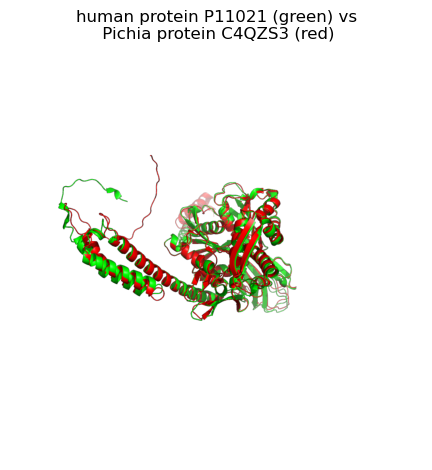

CmdException:  Error: Invalid selection name "A0A1B2JHD1".
A0A1B2JHD1<--

In [5]:
def png_save(path, title="image"):
    """Save the current PyMOL view as a PNG image."""
    print(f"Image saved to {path}")
    
    cmd.ray(width=1000, height=1000)
    cmd.png(path)

    img = mpimg.imread(path)
    plt.imshow(img)    
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(path)
    plt.show()


for i, pichia_prot in enumerate(pichia_proteins):
    print(pichia_prot)
    cmd.do(f"fetchAF2 {pichia_prot}")
    cmd.color("red", pichia_prot)
    cmd.align(pichia_prot, human_prot)
    cmd.zoom()
    

    path = f'images/{pichia_prot}_vs_{human_prot}.png'
    title= f"human protein {human_prot} (green) vs\n Pichia protein {pichia_prot} (red)"
    
    png_save(path, title)
    cmd.do(f"hide everything, {pichia_prot}")

for i, pichia_prot in enumerate(pichia_proteins):
    cmd.do(f"show_as cartoon, {pichia_prot}")

Fetch the identified proteins.